# Understanding and Predicting Stroke Events using Clinical Features

## Heathcare Data Science and Analytics
***

## Table of Contents
### The Problem
- [Signifying the Importance of Predicting a Stoke Event](#problem)

### Data Quality Check
- [Inspection of Data](#datacleaning)

### Descriptive Statistics
- [Summary Statistics, Stroke Rate, Size of Data](#descriptive_statistics)
- [Correlation Matrix](#correlation_matrix)

### Exploratory Data Analysis (EDA)



***
### Objectives: 
- To understand what factors contributed most to a patient getting a stroke.

- To find any meaningful patterns of clinical features.

- To create a model that predicts the likelihood of a patient getting a stroke.

- To create or improve different prevention strategies on targeted patients. 

The implementation of this model will allow healthcare professionals to create better decision-making actions.

### This notebook will cover:
1. Descriptive Analytics - What happened?
2. Predictive Analytics - What might happen?
3. Prescriptive Analytics - What should we do?

<a id='problem'></a>
### The Problem:

The World Heath Organisation (WHO) have identified strokes as being the **2nd** leading cause of death globally. Stokes are responsible for approximately **11%** of total deaths.
The task is to predict which patients are likely to develop a stroke using clinical data.

# Import Packages
***

In [356]:
__author__ = "Sophia Bouchama"
__copyright__ = "Copyright 2021. Sophia Bouchama"
__email__ = "hello@sophiabouchama.com"

In [561]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import itertools
%matplotlib inline

# Read the Data
***
Reading in the CSV file containing all the data for this problem.

In [562]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [563]:
# Examine the dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<a id='datacleaning'></a>
# Data Quality Check
***

In [564]:
df.shape

(5110, 12)

There 5110 patient entries and 12 features present in the dataset including the target feature (stroke)


Check for duplicates in the dataset:

In [565]:
print(df.duplicated().sum())

0


In [566]:
df['id'].nunique()

5110

We can confirm that patient id is unique in the dataset, therefore this column is dropped.
ID is used for unique patient identification and provides us with no useful insights or meaningful information.

In [567]:
df = df.drop(columns='id')

In [568]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [569]:
# Check to see if there are any missing values in our data set
df.isnull().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

Missing 'bmi' values observed.

Define the categorical and numerical variables into separate list variables to be used later on:

In [573]:
# Select all the columns with 'object' datatype and define as categorical
categorical = df.select_dtypes(include=['object']).columns.tolist()

# Select all the columns with 'int64' datatype and define as numerical
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove stroke from the list as it is the target feature
numerical.remove('stroke')

print('categorical variables:', categorical)
print('numerical variables:', numerical)

categorical variables: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical variables: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In our dataframe we can see that we have 10 features in total. We can identify the categorical and numerical values as follows.

Categorical features:
- gender 
- ever_married
- work_type
- residence_type
- smoking status

Numerical features:
- age
- hypertension
- avg_glucose_level
- heart_disease
- bmi

Check to see if there is any categorical values in our data set that are unmeaningful or corrupt:

In [367]:
# Iterate through each categorical feature 
# Find unique values with their value counts to see how many units of each variable is present

for feature in categorical:    
    print(df[feature].value_counts().to_frame(), '\n')

        gender
Female    2994
Male      2115
Other        1 

     ever_married
Yes          3353
No           1757 

               work_type
Private             2925
Self-employed        819
children             687
Govt_job             657
Never_worked          22 

       Residence_type
Urban            2596
Rural            2514 

                 smoking_status
never smoked               1892
Unknown                    1544
formerly smoked             885
smokes                      789 



All values of the features make logical sense

In [368]:
# Display the statistical overview of the categorical data
df.describe(include=[np.object])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [369]:
# Display the statistical overview of the numerical data
# Check minimum and maximum value for each column 
# Check for outliers or corrupt data
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


<a id='Missing Data'></a>
# Missing Data

### 1) BMI (Numerical Variable)

The 'bmi' column is the only numerical attribute with missing data, consisting of 201 null (NaN) values. 

We can calulate that 3.93% of the BMI data is missing:

Percentage of values missing = number of missing values / (number of missing values + number of present values) * 100

In [370]:
# Calculating how many BMI values are present and missing
df['bmi'].isnull().value_counts()

False    4909
True      201
Name: bmi, dtype: int64

In [371]:
# Calculating percentage of missing BMI values and round to 2dp
missing_vals = df['bmi'].isnull().sum()
present_vals = len(df) - df['bmi'].isnull().sum()

missing_bmi_values = (missing_vals / (missing_vals + present_vals)) * 100

missing_bmi_values.round(2)

3.93

In order to deal with the missing values, I will replace the missing data with the average value.
Replacing missing values will have some impact on the data by reducing the accuracy. However, since the percentage of missing values is small, this will have a small effect. This would be the better solution than to drop the column completely since BMI could have a significant impact on the causation of stroke.

In [372]:
# Replace missing BMI values with the mean
mean_bmi = df['bmi'].mean()
df['bmi'].replace(np.nan, mean_bmi, inplace=True)

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### 2) Gender (Categorical Variable)

The 'gender' column consists of 3 unique values: Male, Female and Other. Since there is only 1 patient categorised as 'Other' this row will be dropped since the size is very small and insignfificant to the dataset.


In [373]:
df = df[df['gender'] != 'Other']

### 3) Smoking Status (Categorical Variable)

The 'smoking status' column consists of 4 unqiue values: never smoked, smokes, formerly smoked and unknown. Since a large proportion of the class is 'unknown' (1544 patients), it will be kept as 'unknown' category and not dropped.

<a id='descriptive_statistics'></a>
# Exploratory Data Analysis
***

In [374]:
# How many patients are in the dataset?
df.shape

(5109, 11)

In [375]:
# Calculate the stroke rate of the healthcare dataset.
stroke_rate = df.stroke.value_counts() / df.shape[0]
stroke_rate

0    0.951262
1    0.048738
Name: stroke, dtype: float64

The distribution of the target feature shows there is a large class imbalance:

- Approx 95% of the data are in the non-stroke class

- Approx 5% of the data are in the stroke class

<AxesSubplot:xlabel='stroke', ylabel='count'>

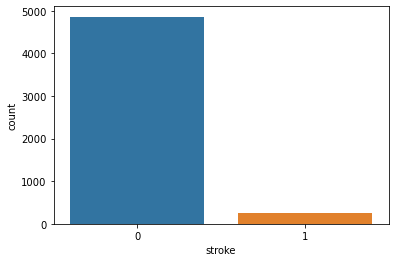

In [553]:
sns.countplot(x="stroke", data=df)

In [377]:
# Display the statistical overview of the patients (numerical data)
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894508,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


avg_glucose_level appears to be slightly skewed to the right since the median is less than the mean.

The descriptive statistics of the other numerical data shows that the other continuous numerical features (age and bmi) do not appear to be skewed, since median and mean are similar. Therefore data transofrmation based on distribution is not necessary.

Plotting the numerical features in acsending order against their index in order to view how features are distributed. From this outliers can be detected by visual insepction.

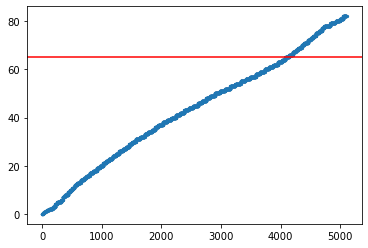

In [378]:
age_sorted_df = df.sort_values(by=['age'])

patient_id = []
for patient in range(len(age_sorted_df['age'])):
    patient_id.append(patient)

x = patient_id
y = age_sorted_df['age']
plt.scatter(x, y, s=5)
plt.axhline(y=65, color='r') 

The age range appears to be evenly distrubted and visually cannot see any outliers. 

The minimum age is 0.08 years which is approximately 1 month old, and maximum age is 82 years which falls within the range of human life expectancy.

I further investigated the minimum age value with regards to likihood of strokes. According to kidshealth.org, strokes in babys are uncommon but most often happen within the first month after birth. Therefore, I have decided to keep the age range for now, as we may extract some value from stroke data in young age groups.


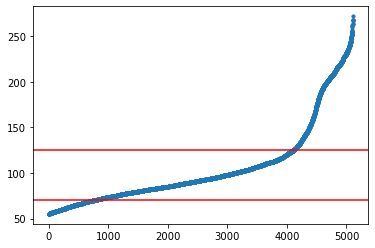

In [379]:
avg_glucose_level_sorted = sorted(df['avg_glucose_level'])
patient_id = []
for patient in range(len(avg_glucose_level_sorted)):
    patient_id.append(patient)

x = patient_id
y = avg_glucose_level_sorted
plt.scatter(x, y, s=10)
plt.axhline(y=70, color='r')
plt.axhline(y=125, color='r') 

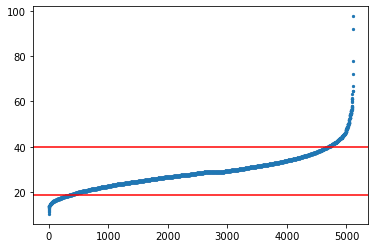

In [380]:
bmi_sorted = sorted(df['bmi'])
patient_id = []
for patient in range(len(bmi_sorted)):
    patient_id.append(patient)

x = patient_id
y = bmi_sorted
plt.scatter(x, y, s=5)
plt.axhline(y=18.5, color='r')
plt.axhline(y=40, color='r')

Below 18.5	Underweight
18.5–24.9	Healthy
25.0–29.9	Overweight
30.0 and above	Obese

In [381]:
# Display the mean summary of patients (Stroke V.S. Non-Stroke). What do you notice between the groups?
stroke_summary = df.groupby('stroke')
stroke_summary.mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.974831,0.088889,0.047119,104.787584,28.826710
1,67.728193,0.265060,0.188755,132.544739,30.217789


In [382]:
stroke_summary.std()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,22.293056,0.284613,0.211916,43.847095,7.776457
1,12.727419,0.442254,0.392102,61.921056,5.825589


<a id='correlation_matrix'></a>
### Correlation Matrix

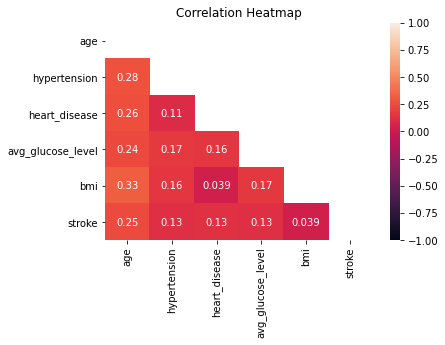

In [412]:
# Create the correlation matrix heatmap. What features correlate the most with stroke? What other correlations did you find?
corr = df.corr()
matrix = np.triu(df.corr())
heatmap = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, mask = matrix, vmin=-1, vmax=1, annot=True)
# Set the title
heatmap.set_title('Correlation Heatmap');


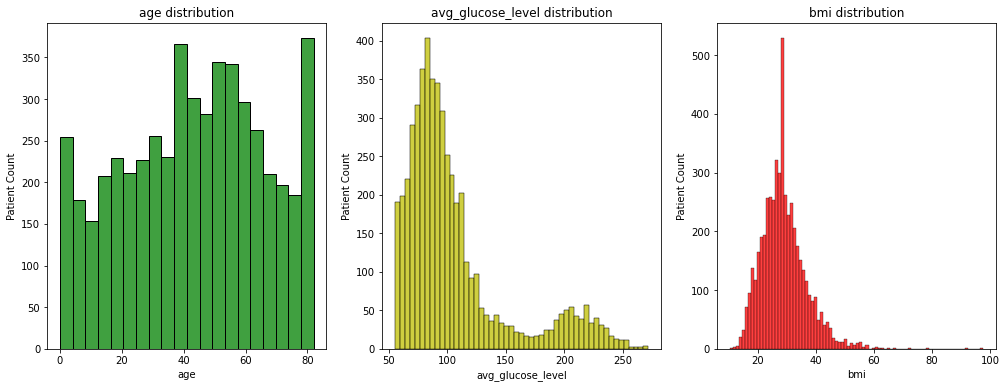

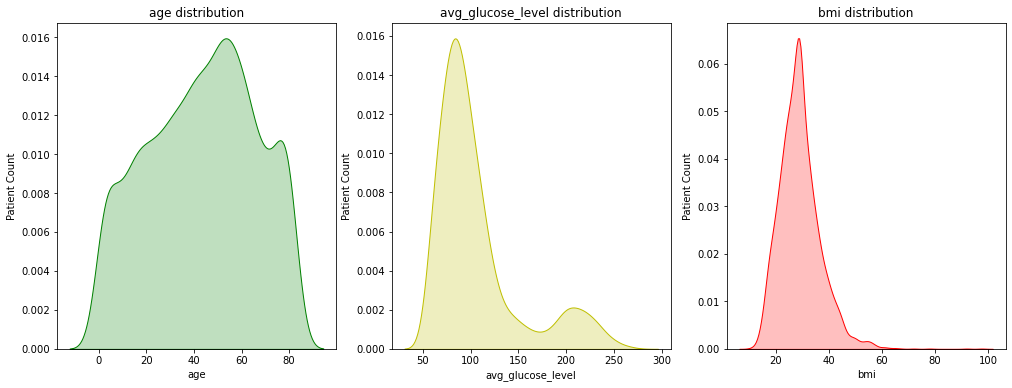

In [546]:
continuous_numerical = ['age','avg_glucose_level','bmi']
# Plot the distribution of clinical patient continuous numerical data: age, average glucose level and BMI. 

# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(17, 6))

#Numerical Feature Distribution
count = 0
color = ['g','y','r']
for feature in continuous_numerical:
    sns.histplot(df[feature], kde=False, color=color[count], ax=axes[count]).set_title(feature + ' distribution')
    axes[count].set_ylabel('Patient Count')
    count = count + 1

#Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(17, 6))

count=0
for feature in continuous_numerical:
    sns.kdeplot(df[feature], color=color[count], fill=True, ax=axes[count]).set_title(feature + ' distribution')
    axes[count].set_ylabel('Patient Count')
    count = count + 1
    

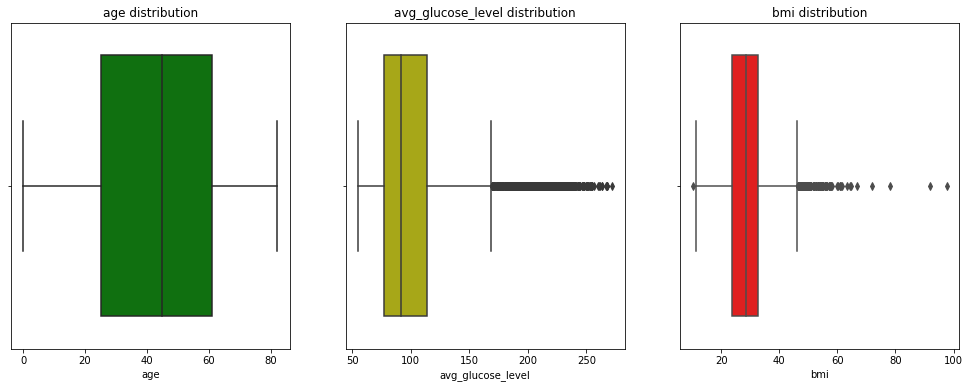

In [385]:
f, axes = plt.subplots(ncols=3, figsize=(17, 6))

count = 0
for feature in continuous_numerical:
    sns.boxplot(x=feature, data=df, color=color[count], ax=axes[count]).set_title(feature + ' distribution')
    count = count +1

avg_glucose_level appears to be positively skewed

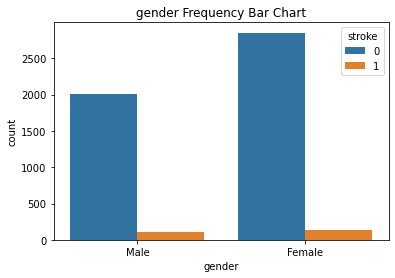

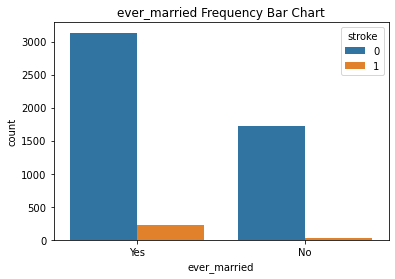

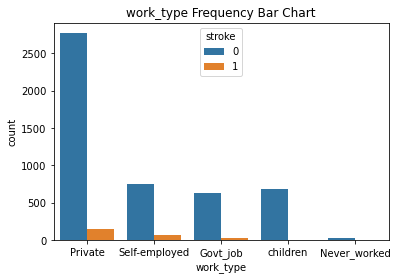

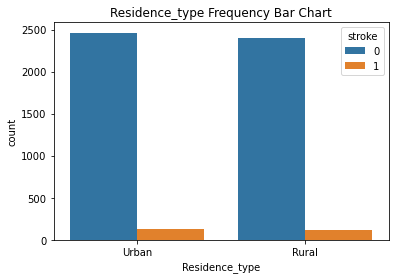

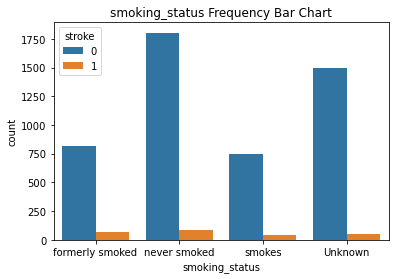

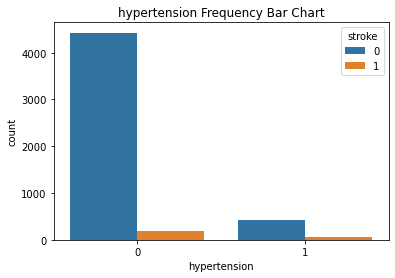

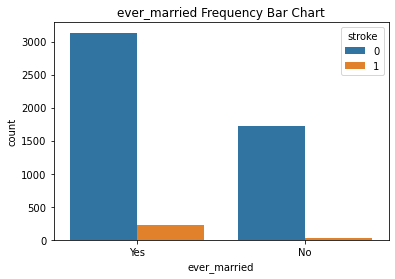

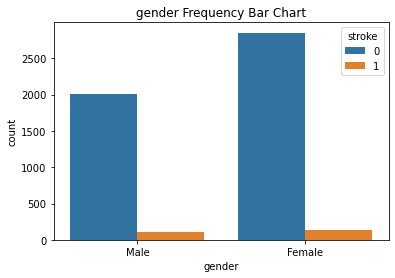

In [520]:
binary = ['hypertension', 'ever_married', 'gender']
categorical_and_binary = categorical + binary

for feature in categorical_and_binary:
    sns.countplot(x=feature, hue="stroke", data=df)
    plt.title(feature + ' Frequency Bar Chart')
    plt.xlabel(feature)
    plt.show()

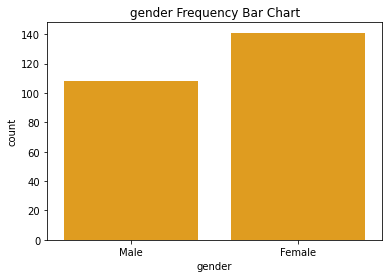

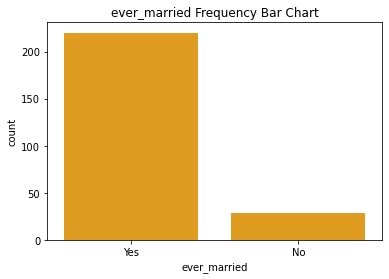

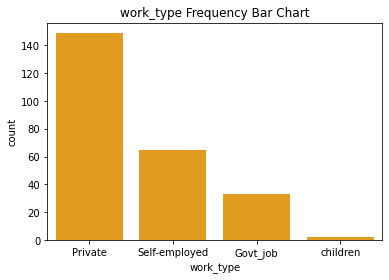

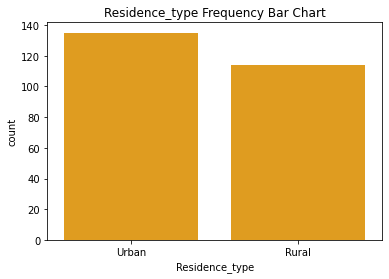

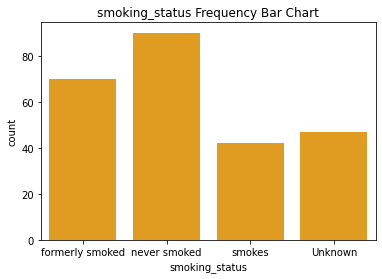

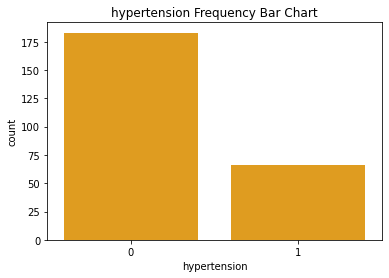

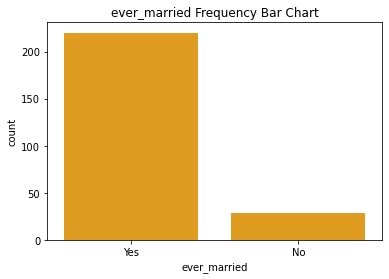

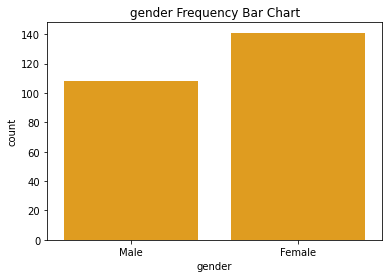

In [390]:
stroke = df["stroke"] == 1
no_stroke = df["stroke"] == 0
for feature in categorical_and_binary:
    sns.countplot(x=df[feature][stroke], color='orange', data=df)
    plt.title(feature + ' Frequency Bar Chart')
    plt.xlabel(feature)
    plt.show()

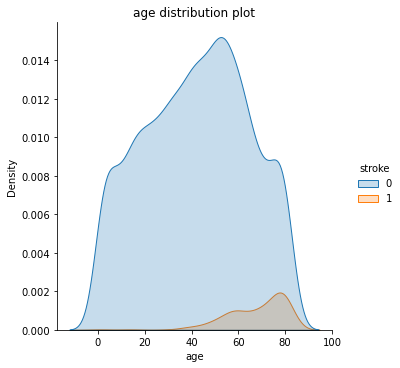

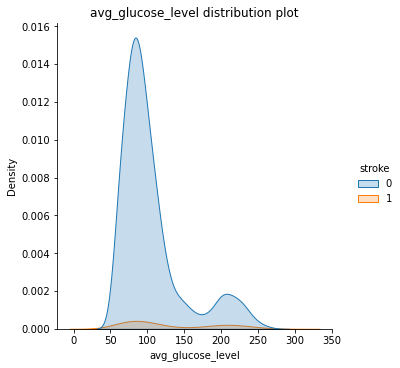

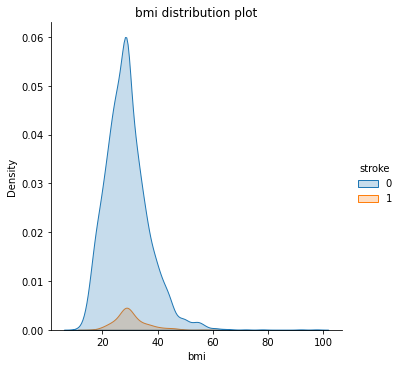

In [467]:
for feature in continuous_numerical:
    sns.displot(df, x=feature, hue="stroke", kind="kde", fill= True)
    plt.title(feature + ' distribution plot')
    plt.xlabel(feature)
    plt.show()

Plot probability density function to see the distribution more clearly:

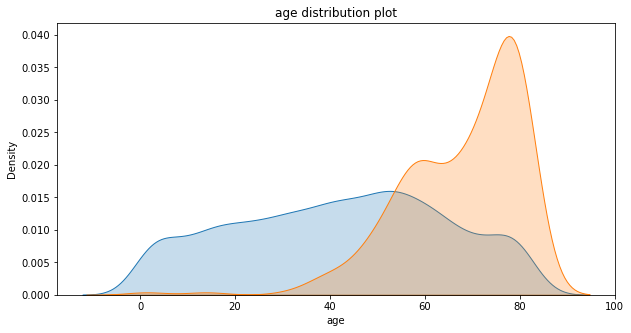

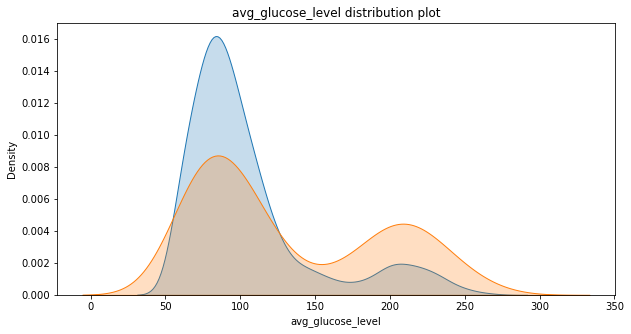

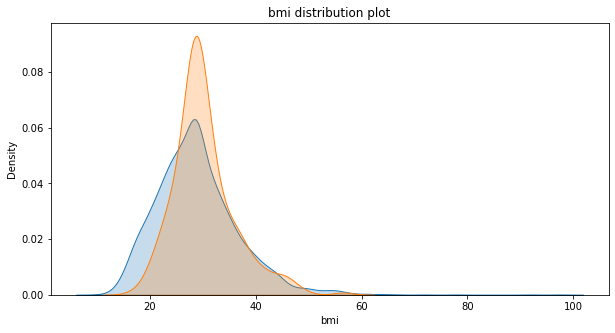

In [548]:
#plt.figure(figsize=(16,6))
#for feature in continuous_numerical:
#    plt.subplot(2, 2, continuous_numerical.index(feature)+1)
#    sns.kdeplot(df[feature][no_stroke], fill= True)
#    sns.kdeplot(df[feature][stroke], fill= True)
#    plt.title(feature + ' distribution plot')
#    plt.xlabel(feature)

for feature in continuous_numerical:
    fig = plt.figure(figsize=(10,5))
    sns.kdeplot(df[feature][no_stroke], fill= True)
    sns.kdeplot(df[feature][stroke], fill= True)
    plt.title(feature + ' distribution plot')
    plt.xlabel(feature)
    plt.show()

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

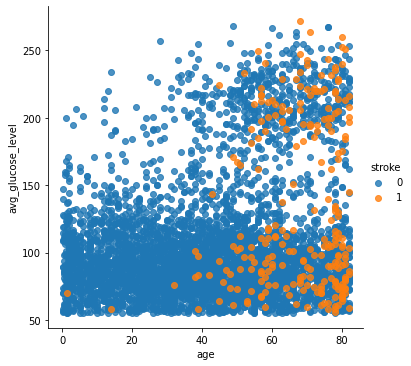

In [ ]:
for feature1,feature2 in itertools.combinations(continuous_numerical, 2):
    sns.lmplot(x=feature1, y=feature2, data=df, fit_reg=False, hue='stroke')
    
sns.lmplot(x=df.bmi, y=df.bmi, data=df, fit_reg=False, hue='stroke')

Next steps:
- change married status, heart diesease, gender to binary - for plotting and maybe for encoding for ML models
- correlation between categorical values ??


- label encode values / one hot encoding 
- train / test split


- choose ML baseline model: 
1) logistic regression

In [559]:
df_encoded = pd.get_dummies(df)
df_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.893237,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.000000,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
